In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as functional
import torch.nn.init as init

In [2]:
class SimpleCNN(nn.Module):

    def __init__(self, width_multiplier: int, use_batchnorm=False):
        super(SimpleCNN, self).__init__()
        self.width_multiplier = width_multiplier
        self.use_batchnorm = use_batchnorm
        
        self.conv1 = nn.Conv2d(1, 2 * width_multiplier, 5, padding=2)
        self.conv2 = nn.Conv2d(2 * width_multiplier, 4 * width_multiplier, 5, padding=2)
        self.linear: nn.Linear = nn.Linear(4 * width_multiplier * 7 * 7, 64 * width_multiplier)
        self.output = nn.Linear(64 * width_multiplier, 10)
        
        def initialize_weights(module: nn.Module):
            if module != self:
                init.normal(module.weight.data, mean=0.0, std=0.1)
        
        self.apply(initialize_weights)
    
    def forward(self, x: autograd.Variable) -> autograd.Variable:
        y = functional.max_pool2d(functional.relu(self.conv1(x)), 2)
        y = functional.max_pool2d(functional.relu(self.conv2(y)), 2)
        y = functional.relu(self.linear(y.view(-1, 4*self.width_multiplier*7*7)))
        y = self.output(y)
        return y


# Now, we test the network to see if it works. 
net = SimpleCNN(1)
print(net(autograd.Variable(torch.rand((2, 1, 28, 28)))))

Variable containing:
 0.2333  0.0386 -0.1757  0.5129 -0.3680 -0.0277 -0.0404  0.0653  0.3291  0.1256
 0.2515  0.0269 -0.2324  0.6073 -0.3457 -0.0622 -0.0633  0.0669  0.2966  0.1034
[torch.FloatTensor of size 2x10]



In [3]:
import typing
import numpy.testing as testing


def fsgm(image_batch: torch.FloatTensor,
         label_batch: torch.LongTensor,
         model: typing.Callable[[autograd.Variable], autograd.Variable],
         objective: typing.Callable[[autograd.Variable, autograd.Variable], autograd.Variable],
         eps: float):
    """Takes a batch of images, and modifies each image using the FGSM attack."""
    for i in range(image_batch.shape[0]):
        x = autograd.Variable(torch.unsqueeze(image_batch[i], 0), requires_grad=True)
        label = autograd.Variable(label_batch[i:i+1])
        output: autograd.Variable = model(x)
        loss: autograd.Variable = objective(output, label)
        loss.backward()
        x.data += eps*torch.sign(x.grad.data)
        torch.clamp(x.data, min=0.0, max=1.0, out=x.data)


# Now, we test to see there are no obvious errors. 
def test_fsgm():
    net = SimpleCNN(1)
    image = torch.zeros((1, 1, 28, 28)) + 0.5
    label = torch.LongTensor([2])
    perturbed_image = image.clone()
    fsgm(perturbed_image, label, net, nn.CrossEntropyLoss(), 0.3)
    perturbation = torch.abs(perturbed_image - image)
    testing.assert_almost_equal(
            perturbation.numpy(),
            ((perturbation > 0).float()*0.3).numpy(),
            15)


def test_fsgm_no_errors_on_cuda():
    net = SimpleCNN(1)
    net.cuda()
    image: torch.FloatTensor = (torch.zeros((1, 1, 28, 28)) + 0.5).cuda()
    label = torch.LongTensor([2]).cuda()
    perturbed_image: torch.FloatTensor = image.clone()
    assert perturbed_image.is_cuda
    fsgm(perturbed_image, label, net, nn.CrossEntropyLoss(), 0.3)


for i in range(10):
    test_fsgm()
test_fsgm_no_errors_on_cuda()

# What did we learn from this test? How to handle possible zero-gradients. Also, when doing random
# initializations, test a few times to make sure that nothing can go wrong with tests. 

In [4]:
def pgd(image_batch: torch.FloatTensor,
        label_batch: torch.LongTensor,
        model: typing.Callable[[autograd.Variable], autograd.Variable],
        objective: typing.Callable[[autograd.Variable, autograd.Variable], autograd.Variable],
        eps: float,
        alpha: float,
        num_steps: int,
        num_restarts: int):
    """Runs PGD on the negative of the given loss function with the given parameters on the given image."""
    
    def pgd_without_restarts(sample_index: int):
        """PGD on negative of the loss function. This has no random restarts."""
        image = image_batch[sample_index]
        x_min = torch.clamp(image - eps, min=0.0)
        x_max = torch.clamp(image + eps, max=1.0)
        random_perturbation = torch.rand(image.shape)*eps
        if image_batch.is_cuda:
            random_perturbation = random_perturbation.cuda()
        random_start = torch.clamp(image + random_perturbation, min=0.0, max=1.0)
        x = autograd.Variable(torch.unsqueeze(random_start, 0), requires_grad=True)
        for i in range(num_steps):
            output = model(x)
            label = autograd.Variable(label_batch[sample_index:sample_index + 1])
            loss = objective(output, label)
            loss.backward()
            x.data += alpha*torch.sign(x.grad.data)
            x.data = torch.min(torch.max(x.data, x_min), x_max)
            x.grad.data.fill_(0)
        return x.data, loss.data[0]
    
    max_loss = -float("inf")
    best_perturbed_image = None
    for i in range(image_batch.shape[0]):
        for _ in range(num_restarts):
            perturbed_image, loss = pgd_without_restarts(i)
            if loss > max_loss:
                max_loss = loss
                best_perturbed_image = perturbed_image
        image_batch[i] = best_perturbed_image


def test_no_runtime_errors():
    net: SimpleCNN = SimpleCNN(1)
    image: torch.FloatTensor = torch.rand((2, 1, 28, 28))
    label: torch.LongTensor = torch.LongTensor([2, 2])
    net.zero_grad()
    pgd(image, label, net, nn.CrossEntropyLoss(), 0.3, 0.6, 4, 2)


def test_no_runtime_errors_on_cuda():
    net: SimpleCNN = SimpleCNN(1)
    net.cuda()
    image: torch.FloatTensor = torch.rand((2, 1, 28, 28)).cuda()
    label: torch.LongTensor = torch.LongTensor([2, 2]).cuda()
    net.zero_grad()
    pgd(image, label, net, nn.CrossEntropyLoss(), 0.3, 0.6, 4, 2)


# A more fine-grained test. We will create a specific linear model and test that the resulting images fall within a
# certain range. 
class LinearModel(nn.Module):
    def __init__(self, label: int):
        super(LinearModel, self).__init__()
        self.linear: nn.Linear = nn.Linear(1*28*28, 10)
        self.linear.weight.data.fill_(0)
        self.linear.weight.data[label, :].fill_(1)
    
    def forward(self, x: autograd.Variable):
        y: autograd.Variable = x.view((-1, 1*28*28,))
        return y


def test_linear_model():
    lin = LinearModel(2)
    testing.assert_almost_equal(lin.linear.weight.data[0:2, :].numpy(), torch.zeros((2, 28*28)).numpy(), 15)
    testing.assert_almost_equal(lin.linear.weight.data[2, :].numpy(), torch.ones((28*28,)).numpy(), 15)
    testing.assert_almost_equal(lin.linear.weight.data[3:, :].numpy(), torch.zeros((7, 28*28)).numpy(), 15)


def dummy_loss_function(output_batch: autograd.Variable, label_batch: autograd.Variable) -> autograd.Variable:
    return -0.5*torch.sum(nn.MSELoss(reduce=False)(output_batch, autograd.Variable(torch.zeros(
        output_batch.data.shape))), dim=1)


def test_dummy_loss_function():
    identity: autograd.Variable = autograd.Variable(torch.eye(2, 10))
    expected_result: autograd.Variable = autograd.Variable(-0.5*torch.ones((2,)))
    testing.assert_equal(dummy_loss_function(identity, None).data.numpy(), expected_result.data.numpy())


def test_single_step_pgd():
    image: torch.FloatTensor = torch.zeros(2, 1, 28, 28) + 0.5
    labels: torch.LongTensor = torch.LongTensor([2, 2])
    perturbed_image: torch.FloatTensor = image.clone()
    pgd(perturbed_image, labels, LinearModel(2), dummy_loss_function, 0.3, 1.0, 1, 20)
    testing.assert_almost_equal(perturbed_image.numpy(), torch.zeros(image.shape) + 0.2)


def test_multistep_pgd():
    image: torch.FloatTensor = torch.zeros(2, 1, 28, 28) + 0.5
    labels: torch.LongTensor = torch.LongTensor([2, 2])
    perturbed_image: torch.FloatTensor = image.clone()
    pgd(perturbed_image, labels, LinearModel(2), dummy_loss_function, eps=0.3, alpha=0.01, num_restarts=1, num_steps=10)
    
    image_min: torch.FloatTensor = torch.clamp(image - 0.3, min=0.0)
    
    # Calculate image max
    image_max: torch.FloatTensor = image + 0.3
    for _ in range(10):
        image_max = image_max - 0.01*image_max
    image_max = torch.max(image_max, image_min)
    
    testing.assert_array_less(image_min, perturbed_image)
    testing.assert_array_less(perturbed_image, image_max)


test_no_runtime_errors()
test_no_runtime_errors_on_cuda()
test_dummy_loss_function()
test_linear_model()
test_single_step_pgd()
test_multistep_pgd()

In [5]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms


image_transform = transforms.Compose([
    transforms.ToTensor()])
label_transform: typing.Callable[[int], torch.LongTensor] = lambda x: torch.LongTensor([x])


# Now we need to import MNIST and transform it. 
training_dataset = datasets.MNIST("mnist", train=True, download=True, transform=image_transform, 
                                  target_transform=label_transform)
testing_dataset = datasets.MNIST("mnist", train=False, download=True, transform=image_transform,
                                 target_transform=label_transform)
print(len(training_dataset))
print(type(training_dataset[0][0]))
print(type(training_dataset[0][1]))
print(len(testing_dataset))
print(type(testing_dataset[0][0]))
print(type(testing_dataset[0][1]))

60000
<class 'torch.FloatTensor'>
<class 'torch.LongTensor'>
10000
<class 'torch.FloatTensor'>
<class 'torch.LongTensor'>


From the above code, I learned the following:
* MNIST dataset, without transforms, consists of a list of tuples; each tuple has two elements: a PIL image (28x28) and an integer label (0-9). 
* The above applies for both the training and testing set. 
* The target_transform is used to transform the label, while the transform is used to transform the image. 

Now, we need to concatenate the dataset into one large tensor so that it can be modified with the FGSM and PGD methods. 

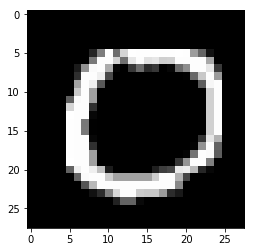

In [6]:
%matplotlib inline

import random

import matplotlib.pyplot as pyplot


training_images: torch.FloatTensor = torch.zeros((len(training_dataset), 1, 28, 28)).float()
training_labels: torch.LongTensor = torch.zeros((len(training_dataset),)).long()
testing_images: torch.FloatTensor = torch.zeros((len(training_dataset), 1, 28, 28)).float()
testing_labels: torch.LongTensor = torch.zeros((len(training_dataset),)).long()

for index, (image, label) in enumerate(training_dataset):
    training_images[index] = torch.unsqueeze(image, 0)
    training_labels[index:index + 1] = label

for index, (image, label) in enumerate(testing_dataset):
    testing_images[index] = torch.unsqueeze(image, 0)
    testing_labels[index:index + 1] = label

pyplot.imshow(training_images[random.randint(0, len(training_images) - 1)].squeeze().numpy(), cmap='gray')

With our images and labels as the proper datatypes (FloatTensor size Nx1x28x28 and LongTensor size N, respectively), we can now run FGSM and PGD on each batch. Due to torch's easy semantics for dealing with CUDA, all we need to do is put everything on the GPU and run our experiment. 

In [10]:
import time
import typing


class Stopwatch:
    """
    A class that operates a stopwatch. Basic functions include start(), stop(), lap(),
    and get_lap_times(). All returned times are in seconds. The accuracy of the stopwatch
    is the accuracy of the time.perf_counter() command. 
    """
    
    def __init__(self):
        self._is_stopped = True
        self._last_time: float = 0  # The last time that either start() or lap() was called. 
        self._current_lap_time: float = 0
        self._lap_times: typing.List[float] = []
    
    def start(self):
        if self._is_stopped:
            self._last_time = time.perf_counter()
            self._is_stopped = False
    
    def stop(self):
        if not self._is_stopped:
            current_time = time.perf_counter()
            self._current_lap_time += current_time - self._last_time
            self._is_stopped = True
    
    def lap(self):
        if not self._is_stopped:
            current_time = time.perf_counter()
            self._lap_times.append(current_time - self._last_time + self._current_lap_time)
            self._last_time = current_time
            self._current_lap_time = 0
    
    def lap_times(self) -> typing.List[float]:
        return [t for t in self._lap_times]
    
    def reset(self):
        self._is_stopped = True
        self._current_lap_time = 0
        self._lap_times = []


def run_stopwatch():
    # Should print, approximately, '[1, 2, 3]\n[1, 2, 3]\n'
    s = Stopwatch()
    for _ in range(2):
        s.start()
        time.sleep(1)
        s.lap()
        time.sleep(1)
        s.stop()
        time.sleep(1)
        s.start()
        time.sleep(1)
        s.lap()
        time.sleep(3)
        s.lap()
        s.stop()
        print(s.lap_times())
        s.reset()


[1.001049919000252, 2.002196190000177, 3.003206451000551]


[1.0010581020005702, 2.0021059290002086, 3.003054845999941]


In [14]:
import collections
import functools


# Let's generate figure 4!

training_images = training_images.cuda()
training_labels = training_labels.cuda()
testing_images = testing_images.cuda()
testing_labels = testing_labels.cuda()


def natural(*args, **kwargs):
    pass


def train_simple_cnn(training_attack: str, testing_attack: str, capacity_scale: int,
                     batches_between_outputs=10) -> [float, float]:
    """
    Trains an instance of SimpleCNN with the given capcity scale on training images, which were perturbed via 
    training_attack, and then tests the resulting model on testing images, which were perturbed via testing_attack.
    Note that perturbations on the training images are recomputed for each batch, since the attacks depend on the
    state of the current model instance. The accuracy (and loss) of the model on the test images is returned. 
    
    This method is used to generate a single point on one of the plots in the top half of Figure 4. 
    
    :param training_attack: One of {'natural', 'fgsm', 'pgd'}.
    :param testing_attack: One of {'natural', 'fgsm', 'pgd'},
    :param capacity_scale: One of {1, 2, 4, 8, 16}. 
    :return: The accuracy and loss of the trained model on the test set. 
    """
    
    net = SimpleCNN(capacity_scale)
    net.cuda()
    
    def get_attack_function(name: str) -> typing.Callable[[torch.FloatTensor, torch.LongTensor], None]:
        if name == 'natural':
            return natural
        elif name == 'fgsm':
            return functools.partial(fsgm, model=net, objective=nn.CrossEntropyLoss(), eps=0.3)
        elif name == 'pgd':
            return functools.partial(pgd, model=net, objective=nn.CrossEntropyLoss(), eps=0.3, alpha=0.01,
                                     num_steps=40, num_restarts=1)
    
    training_attack = get_attack_function(training_attack)
    testing_attack = get_attack_function(testing_attack)
    
    shuffled_indexes = torch.randperm(len(training_images)).cuda()
    shuffled_training_images = training_images[shuffled_indexes]
    shuffled_training_labels = training_labels[shuffled_indexes]
    
    stopwatches: typing.DefaultDict[str, Stopwatch] = collections.defaultdict(Stopwatch)
    
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    batch_start_index = 0
    batch_size = 50
    num_steps = 5
    for step in range(num_steps):
        stopwatches['step'].start()
        
        stopwatches['setup'].start()
        batch_shape = (batch_size,) + training_images[0, :, :, :].shape
        batch_images: torch.FloatTensor = torch.zeros(batch_shape).float().cuda()
        batch_labels: torch.LongTensor = torch.zeros((batch_size,)).long().cuda()
        batch_images.copy_(shuffled_training_images[batch_start_index:batch_start_index + batch_size])
        batch_labels.copy_(shuffled_training_labels[batch_start_index:batch_start_index + batch_size])
        stopwatches['setup'].lap()
        stopwatches['setup'].stop()
        
        stopwatches['attack'].start()
        training_attack(batch_images, batch_labels)
        stopwatches['attack'].lap()
        stopwatches['attack'].stop()
        
        stopwatches['forward'].start()
        output = net(autograd.Variable(batch_images))
        stopwatches['forward'].lap()
        stopwatches['forward'].stop()
        
        loss: autograd.Variable = functional.cross_entropy(output, autograd.Variable(batch_labels))
        net.zero_grad()
        
        stopwatches['backward'].start()
        loss.backward()
        stopwatches['backward'].lap()
        stopwatches['backward'].stop()
        
        stopwatches['update'].start()
        optimizer.step()
        stopwatches['update'].lap()
        stopwatches['update'].stop()
        
        stopwatches['step'].lap()
        stopwatches['step'].stop()
        if step % batches_between_outputs == 0:
            _, predictions = torch.max(output.data, 1)
            fraction_correct = float((predictions == batch_labels).sum())/batch_size
            print(
                'Step {0}: loss={1}, accuracy={2}, duration={3}'.format(
                    str(step), str(loss.data[0]), str(fraction_correct), str(stopwatches['step'].lap_times()[-1])))
        
        # OH MY GOD
        # I SPENT A WEEK WRITING THIS
        # AND I FORGOT TO INCREMENT THE BATCH INDEX
        # NO WONDER THE PERFORMANCE SUCKED
        
        batch_start_index = (batch_start_index + batch_size) % len(training_images)
    
    for name, stopwatch in stopwatches.items():
        print(name + ": " + str(stopwatch.lap_times()))
    return 0.0, 0.0
    
    testing_batch_size = 100  # Must divide len(testing_images).
    total_loss = 0.0
    total_correct = 0
    num_samples = 0
    for batch_index in range(int(len(testing_images)/testing_batch_size)):
        batch_images: torch.FloatTensor = torch.zeros(
            (testing_batch_size,) + testing_images[0, :, :, :].shape).float().cuda()
        batch_labels: torch.LongTensor = torch.zeros((testing_batch_size,)).long().cuda()
        batch_images.copy_(testing_images[batch_index * testing_batch_size:(batch_index + 1)*testing_batch_size])
        batch_labels.copy_(testing_labels[batch_index * testing_batch_size:(batch_index + 1)*testing_batch_size])
        testing_attack(batch_images, batch_labels)
        output: autograd.Variable = net(autograd.Variable(batch_images))
        loss: autograd.Variable = functional.cross_entropy(output, autograd.Variable(batch_labels), size_average=False)
        _, predictions = torch.max(output.data, 1)
        total_correct += (predictions == batch_labels).sum()
        total_loss += loss.data[0]
        num_samples += testing_batch_size
    
    return total_loss/num_samples, float(total_correct)/num_samples


# For our sanity check, we want to train the network on PGD and test it on FGSM; the accuracy should be about 95.6%. 
loss, accuracy = train_simple_cnn('pgd', 'fgsm', 16)
print('PGD training vs. FGSM attack: loss={0}, accuracy={1}'.format(loss, accuracy))

Step 0: loss=24.453327178955078, accuracy=0.04, duration=2.500127602000248


step: [2.500127602000248, 2.432737095000448, 2.378695799000525, 2.361024169999837, 2.368802637999579]
setup: [0.00775164000060613, 0.00043373199969209963, 0.005929208999987168, 0.005944301999988966, 0.005837287999383989]
attack: [2.490778893999959, 2.4309864920005566, 2.3714755950004474, 2.353649265000058, 2.361683899000127]
forward: [0.00047837999954936095, 0.0003414690008867183, 0.0003465170002527884, 0.0004134620003242162, 0.00039096100044844206]
backward: [0.0005620250003630645, 0.0005620550000458024, 0.0005325439997250214, 0.0005207569993217476, 0.00048380599946540315]
update: [0.0004085689997737063, 0.00031210599991027266, 0.0003128460002699285, 0.00036908299989590887, 0.00030489300024783006]
PGD training vs. FGSM attack: loss=0.0, accuracy=0.0
